In [19]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
import read_reports as rr
import Differentiated_Body_Composition_Tracker as dbct
from scipy.interpolate import interp1d

In [20]:
anna_old_tt, anna_old_n = rr.extract_data_outfile('../../data/collision_reports/Anna.out')
anna_old_v, anna_old_b = rr.extract_data_impact('../../data/collision_reports/Anna.out')

anna_new_t, anna_new_ty = rr.extract_data_report('../../data/collision_reports/nov 18/anna_new_cr.txt')
anna_new_v, anna_new_b = rr.extract_data_impact('../../data/collision_reports/Anna.out')

# Define the base path and run numbers
base_path = '../../data/collision_reports/nov 26/'
run_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Initialize lists to store results
tt_list = []
n_list = []
v_list = []
b_list = []

# Loop through run numbers
for run in run_numbers:
    tt, n = rr.extract_data_outfile_limited(f"{base_path}run{run}.out", 10e6)
    v, b = rr.extract_data_impact(f"{base_path}run{run}.out")
    tt_list.append(tt)
    n_list.append(n)
    v_list.append(v[:len(tt_list[run-1])])
    b_list.append(b[:len(tt_list[run-1])])

In [24]:
anna_v = anna_old_v

In [21]:
# Create a common grid (e.g., normalized indices or a custom range)
# We'll use the minimum and maximum index range across all arrays
common_grid = np.linspace(0, 1, 100)  # Define 100 points for the common grid

# Interpolate each array onto the common grid
interpolated_data = []
for v in v_list:
    # Create a normalized x-axis for the current array
    x = np.linspace(0, 1, len(v))
    # Interpolate to the common grid
    f = interp1d(x, v, kind='linear', fill_value="extrapolate")
    interpolated_data.append(f(common_grid))

# Convert to a NumPy array (shape: 10 x 100)
data_array = np.array(interpolated_data)

# Calculate mean and stochastic error (standard deviation) on the common grid
mean_values = np.mean(data_array, axis=0)
stochastic_error = np.std(data_array, axis=0)

# Output results
#print("Common Grid:\n", common_grid)
#print("Mean Values:\n", mean_values)
#print("Stochastic Error (Standard Deviation):\n", stochastic_error)

# Optional: Save results to files
#np.savetxt("common_grid.txt", common_grid, header="Common grid points")
#np.savetxt("mean_values.txt", mean_values, header="Mean values across datasets")
#np.savetxt("stochastic_error.txt", stochastic_error, header="Stochastic error across datasets")


In [37]:
v_list = b_list
anna_v = anna_old_b

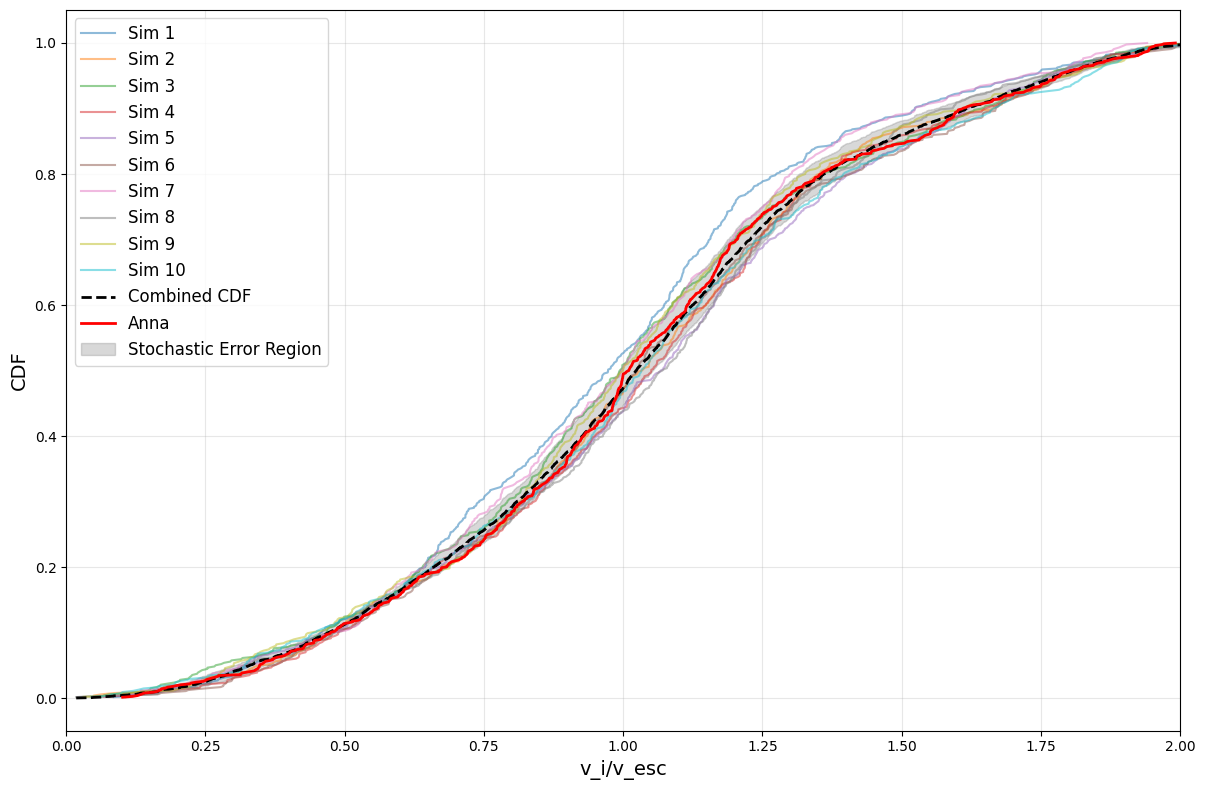

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Example datasets
#v_list = [np.random.rand(np.random.randint(50, 100)) for _ in range(10)]  # Replace with actual data
#anna_v = np.random.rand(200)  # Replace with your "True" dataset

# Step 1: Compute CDFs for each array in v_list
cdf_list = []
for v in v_list:
    sorted_v = np.sort(v)
    cdf = np.arange(1, len(sorted_v) + 1) / len(sorted_v)
    cdf_list.append((sorted_v, cdf))

# Step 2: Combine v_list into one array and compute the combined CDF
combined_v = np.concatenate(v_list)
sorted_combined_v = np.sort(combined_v)
combined_cdf = np.arange(1, len(sorted_combined_v) + 1) / len(sorted_combined_v)

# Step 3: Compute stochastic errors
# Find unique sorted values across all arrays
unique_values = np.unique(np.concatenate([np.sort(v) for v in v_list]))
cdf_at_values = []

for value in unique_values:
    cdf_values = []
    for v, cdf in cdf_list:
        idx = np.searchsorted(v, value, side='right') - 1
        idx = max(min(idx, len(cdf) - 1), 0)  # Ensure index is within bounds
        cdf_values.append(cdf[idx])
    cdf_at_values.append(cdf_values)

cdf_at_values = np.array(cdf_at_values)
mean_cdf = np.mean(cdf_at_values, axis=1)
stochastic_error = np.std(cdf_at_values, axis=1)

# Step 4: Compute the CDF for anna_v
sorted_anna_v = np.sort(anna_v)
anna_cdf = np.arange(1, len(sorted_anna_v) + 1) / len(sorted_anna_v)

# Step 5: Compare anna_v with the combined CDF
anna_cdf_interp = np.interp(unique_values, sorted_anna_v, anna_cdf)
difference = np.abs(mean_cdf - anna_cdf_interp)

# Highlight points where the difference exceeds the stochastic error
out_of_bounds = difference > stochastic_error

# Step 6: Plot results
plt.figure(figsize=(12, 8))

# Plot CDFs of individual arrays
for i, (v, cdf) in enumerate(cdf_list):
    plt.plot(v, cdf, alpha=0.5, label=f'Sim {i+1}')

# Plot the combined CDF
plt.plot(sorted_combined_v, combined_cdf, 'k--', label='Combined CDF', linewidth=2)

# Plot the CDF of anna_v
plt.plot(sorted_anna_v, anna_cdf, 'r-', label='Anna', linewidth=2)

# Plot stochastic error as a shaded region
plt.fill_between(
    unique_values,
    mean_cdf - stochastic_error,
    mean_cdf + stochastic_error,
    color='gray',
    alpha=0.3,
    label='Stochastic Error Region'
)

# Highlight out-of-bounds points
#plt.scatter(unique_values[out_of_bounds], anna_cdf_interp[out_of_bounds], color='red', label='Out of Bounds')

# Finalize plot
#plt.title("CDFs with Stochastic Errors", fontsize=16)
plt.xlabel("v_i/v_esc", fontsize=14)
plt.ylabel("CDF", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
#plt.xscale('log')
plt.xlim(0,2)

# Show the plot
plt.show()


In [39]:
from scipy.stats import ks_2samp

# Combined dataset
combined_v = np.concatenate(v_list)

# Kolmogorov-Smirnov test
ks_stat, p_value = ks_2samp(combined_v, anna_v)

# Print results
print(f"KS Statistic: {ks_stat:.4f}")
print(f"P-Value: {p_value:.6f}")

if p_value < 0.05:
    print("The distributions are significantly different (reject null hypothesis).")
else:
    print("The distributions are not significantly different (fail to reject null hypothesis).")


KS Statistic: 0.0258
P-Value: 0.735781
The distributions are not significantly different (fail to reject null hypothesis).


In [27]:
anna_v

array([ 0.9819,  0.9804,  1.0093,  1.0111,  0.9964,  1.0039,  0.9989,
        1.0161,  0.9914,  1.0264,  1.0015,  1.0153,  1.0432,  1.0928,
        1.0254,  1.0697,  0.988 ,  0.9906,  1.1026,  1.01  ,  0.987 ,
        0.9951,  1.0151,  0.9993,  1.0029,  0.9944,  1.0368,  1.0024,
        1.0073,  1.7047,  2.1162,  1.1828,  1.6167,  0.995 ,  1.173 ,
        1.0183,  3.3182,  1.0519,  1.0284,  1.0522,  1.0009,  1.1046,
        1.164 ,  1.2199,  1.7799,  0.9996,  1.0668,  1.8605,  1.3462,
        1.0442,  1.3838,  1.0297,  2.3787,  1.267 ,  1.2928,  1.1016,
        1.0081,  1.0075,  4.2423,  3.9456,  1.2238,  2.2587,  1.0401,
        1.0042,  1.4102,  1.0195,  1.0764,  1.0521,  2.3803,  1.0164,
        1.1764,  1.236 ,  1.6925,  1.0248,  1.1211,  1.0305,  1.3097,
        1.0064,  1.4254,  1.0387,  1.5871,  1.869 ,  1.8624,  1.0933,
        1.6533,  1.0153,  1.8523,  0.9976,  9.1245,  1.5508,  1.0026,
        2.0429,  1.497 ,  1.267 ,  1.4173,  4.6595,  2.2414,  1.0791,
        1.7259,  7.5